# Installs and imports

In [1]:
!pip3 install transformers==4.25.1 datasets==2.4.0 nvidia-ml-py3==7.352.0 lime torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 KB 9.0 MB/s eta 0:00:00
  Created whee

In [2]:
from datasets import load_dataset
from transformers import (
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    GPT2ForSequenceClassification,
    GPT2Tokenizer,
)
from lime.lime_text import LimeTextExplainer
import torch.nn.functional as F
import torch
from pynvml import (
    nvmlInit,
    nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetMemoryInfo,
    nvmlDeviceGetCount,
    nvmlDeviceGetName,
)
import random

# GPU Benchmarking Utilities

In [3]:
def print_gpu_utilization():
    nvmlInit()
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        info = nvmlDeviceGetMemoryInfo(handle)
        print("Device", i, ":", nvmlDeviceGetName(handle))
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    torch.cuda.empty_cache()


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [4]:
## set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", DEVICE)

## measure GPU utilization
if torch.cuda.is_available():
    print_gpu_utilization()
    torch.ones((1, 1)).to(DEVICE)
    print_gpu_utilization()

Using device cuda
Device 0 : b'Tesla T4'
GPU memory occupied: 253 MB.
Device 0 : b'Tesla T4'
GPU memory occupied: 820 MB.


# Load Model and Tokenizer

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained(
    "microsoft/DialogRPT-updown", model_max_length=1024, cache_dir="./cache/"
)
model = GPT2ForSequenceClassification.from_pretrained(
    "microsoft/DialogRPT-updown",
    num_labels=2,
    ignore_mismatched_sizes=True,
    cache_dir="./cache/",
).to(DEVICE)
model.config.use_cache = False


if torch.cuda.is_available():
    print_gpu_utilization()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialogRPT-updown and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([1, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device 0 : b'Tesla T4'
GPU memory occupied: 2198 MB.


# Data Prep

In [6]:
# split = ["train[:1%]", "test[:1%]"]
split = ["train[:25]", "test[:25]"]
raw_train, raw_test = load_dataset(
    "imdb",
    split=split,
    cache_dir="./cache/",
)

print(len(raw_train))
print(raw_train[2]["text"])
print(raw_train[2]["label"])
print(tokenizer.encode(raw_train[2]["text"]))

train = raw_train.map(
    lambda x: tokenizer(x["text"], truncation=True, padding="max_length"),
    batched=True,
)
test = raw_test.map(
    lambda x: tokenizer(x["text"], truncation=True, padding="max_length"),
    batched=True,
)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to ./cache/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

25
If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />
0
[1532, 691, 284, 3368, 1642, 428, 2099, 286, 2646, 287, 262, 2003, 13, 770, 2646, 318, 3499, 355, 281, 6306, 475, 4952, 645, 43072, 298, 1621, 29847, 1671, 1220, 6927, 1671, 11037, 3198, 1244, 1254, 41276, 329, 5586, 33834, 340, 780, 340, 18105, 319, 523, 867, 30023, 9863, 8643, 2428, 475, 340, 857, 523, 1231, 597, 22024, 540, 20289, 13, 383, 19091, 2058, 1497, 351, 645, 649, 22582, 357, 25252, 530, 2058, 510, 351, 530, 981, 530, 338, 2000, 11569, 364, 11, 355, 

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# Vanilla Training

In [7]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "per_device_train_batch_size": 1,
}

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()
print_summary(result)

The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 25
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 25
  Number of trainable parameters = 354825216


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Time: 24.75
Samples/second: 1.01
Device 0 : b'Tesla T4'
GPU memory occupied: 12832 MB.


# Gradient Accumulation

In [8]:
default_args["gradient_accumulation_steps"] = 4

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()
print_summary(result)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 25
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 6
  Number of trainable parameters = 354825216


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Time: 18.78
Samples/second: 1.33
Device 0 : b'Tesla T4'
GPU memory occupied: 12832 MB.


# Gradient Checkpointing

In [9]:
default_args["gradient_checkpointing"] = True

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()
print_summary(result)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 25
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 6
  Number of trainable parameters = 354825216


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Time: 26.14
Samples/second: 0.96
Device 0 : b'Tesla T4'
GPU memory occupied: 6950 MB.


#Mixed Precision

In [10]:
default_args["fp16"] = True

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()
print_summary(result)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 25
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 6
  Number of trainable parameters = 354825216


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Time: 14.09
Samples/second: 1.77
Device 0 : b'Tesla T4'
GPU memory occupied: 7526 MB.


# Dynamic Padding & Uniform Length Batching

In [11]:
## dynamic padding and smart batching
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

train = raw_train.map(lambda x: tokenizer(x["text"], truncation=True), batched=True)
test = raw_test.map(lambda x: tokenizer(x["text"], truncation=True), batched=True)

trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=collate_fn,
)
result = trainer.train()
print_summary(result)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 25
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 6
  Number of trainable parameters = 354825216


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Time: 5.46
Samples/second: 4.58
Device 0 : b'Tesla T4'
GPU memory occupied: 7570 MB.


#Uncovering the Black Box


    If only to      film   .  film    an   tells  cogent .
 might feel        touches  so many     does so without  discernable motive.         (   up    ' mind wanders,     do   pointless film).
 might   '  staring   window    .

    
     


               .            .
                       .         (       '  ,         ).
    '         .

    
     


    If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.
One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).
One might better spend one's time staring out a window at a tree growing.

    
     


        making       . This     an experiment     .
    for          IMPORTANT issues        .     with   perspectives (    w

<ipython-input-12-08b60b2a8b93>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(tensor_logits).detach().numpy()


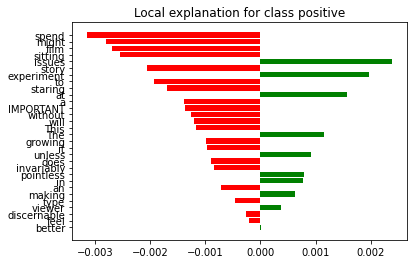

In [12]:
torch.cuda.empty_cache()


def predictor(texts):
    for t in random.sample(texts, 5):
        print(t, "\n")
    tokenized_text = tokenizer(
        texts, return_tensors="pt", padding=True, truncation=True
    )
    tokenized_text.to(DEVICE)
    outputs = model(**tokenized_text)
    tensor_logits = outputs[0].cpu()
    probas = F.softmax(tensor_logits).detach().numpy()
    return probas


def lime_explain():
    text = """
    If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.
One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).
One might better spend one's time staring out a window at a tree growing.

    
    """
    explainer = LimeTextExplainer(class_names=["negative", "positive"])

    exp = explainer.explain_instance(text, predictor, num_features=30, num_samples=25)
    fig = exp.as_pyplot_figure()
    exp.save_to_file("explainable.html")
    fig.show()
    fig.savefig("explainable.jpg")


lime_explain()